Running on PyMC v5.23.0

Data downloaded successfully. Shape: (3899, 5)


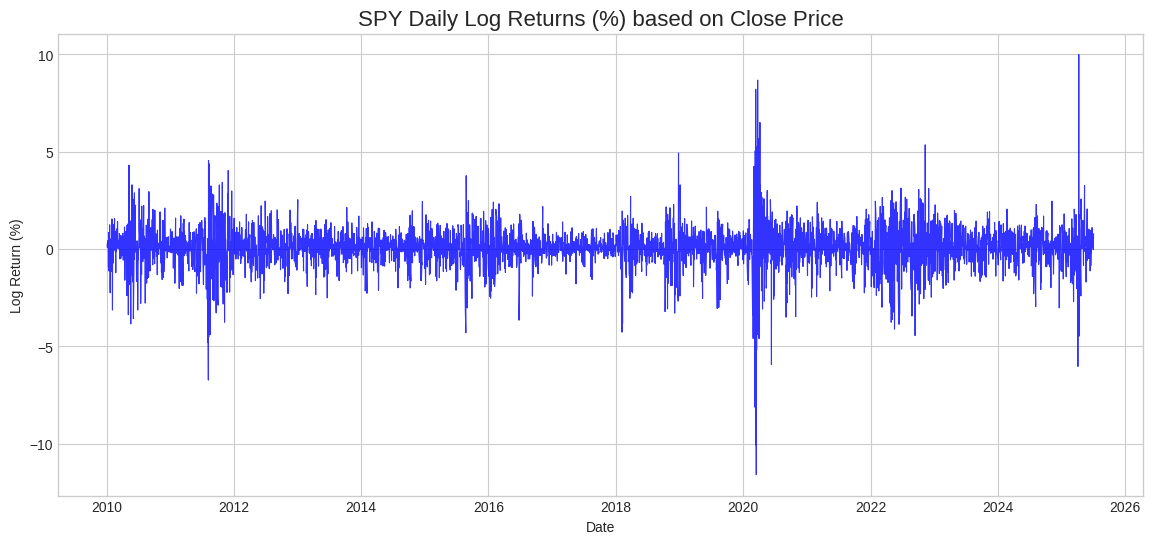


Defining and compiling the SVL model...
Starting MCMC sampling... (This may take several minutes)


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling complete.

Generating diagnostic plots and analyzing results...


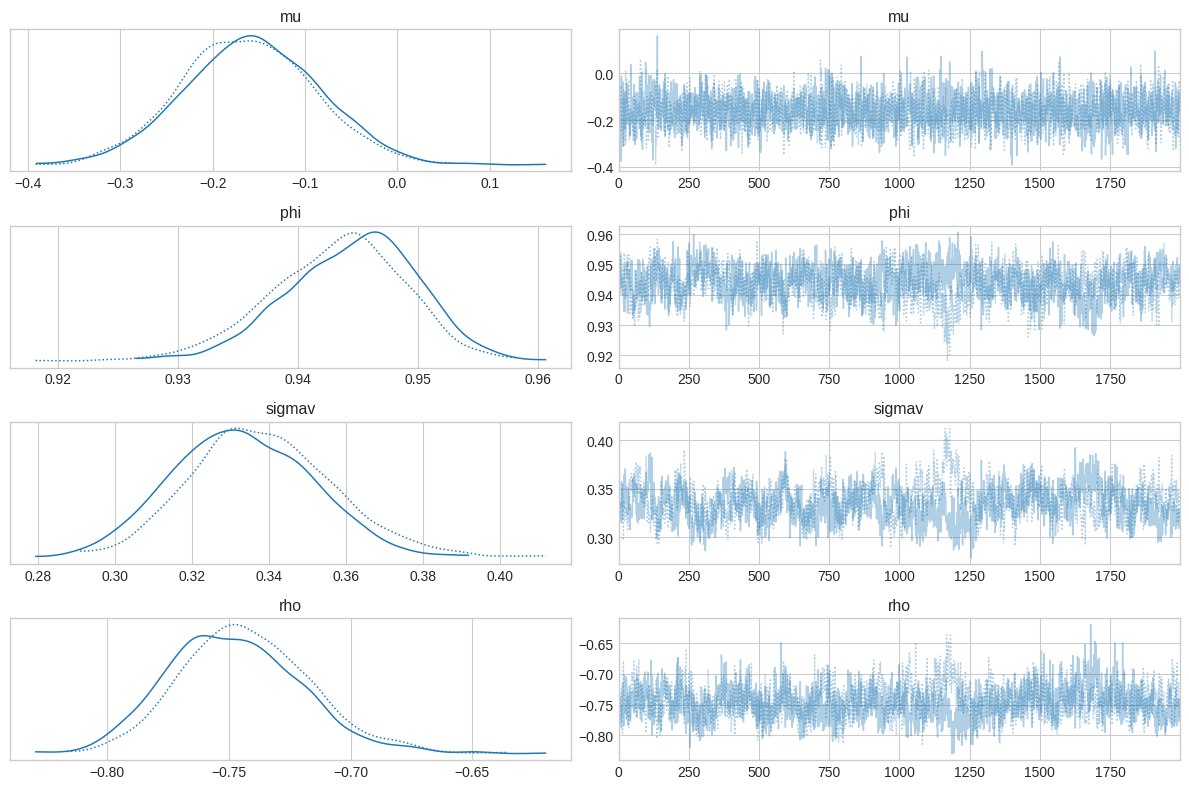


Posterior Summary Statistics:
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     -0.160  0.072  -0.295   -0.027      0.001    0.001    2447.0    2519.0   
phi     0.944  0.006   0.933    0.954      0.000    0.000     164.0     400.0   
sigmav  0.336  0.018   0.303    0.371      0.002    0.001     125.0     214.0   
rho    -0.745  0.027  -0.797   -0.697      0.002    0.001     172.0     373.0   

        r_hat  
mu       1.00  
phi      1.01  
sigmav   1.02  
rho      1.01  

Visualizing the estimated latent volatility...


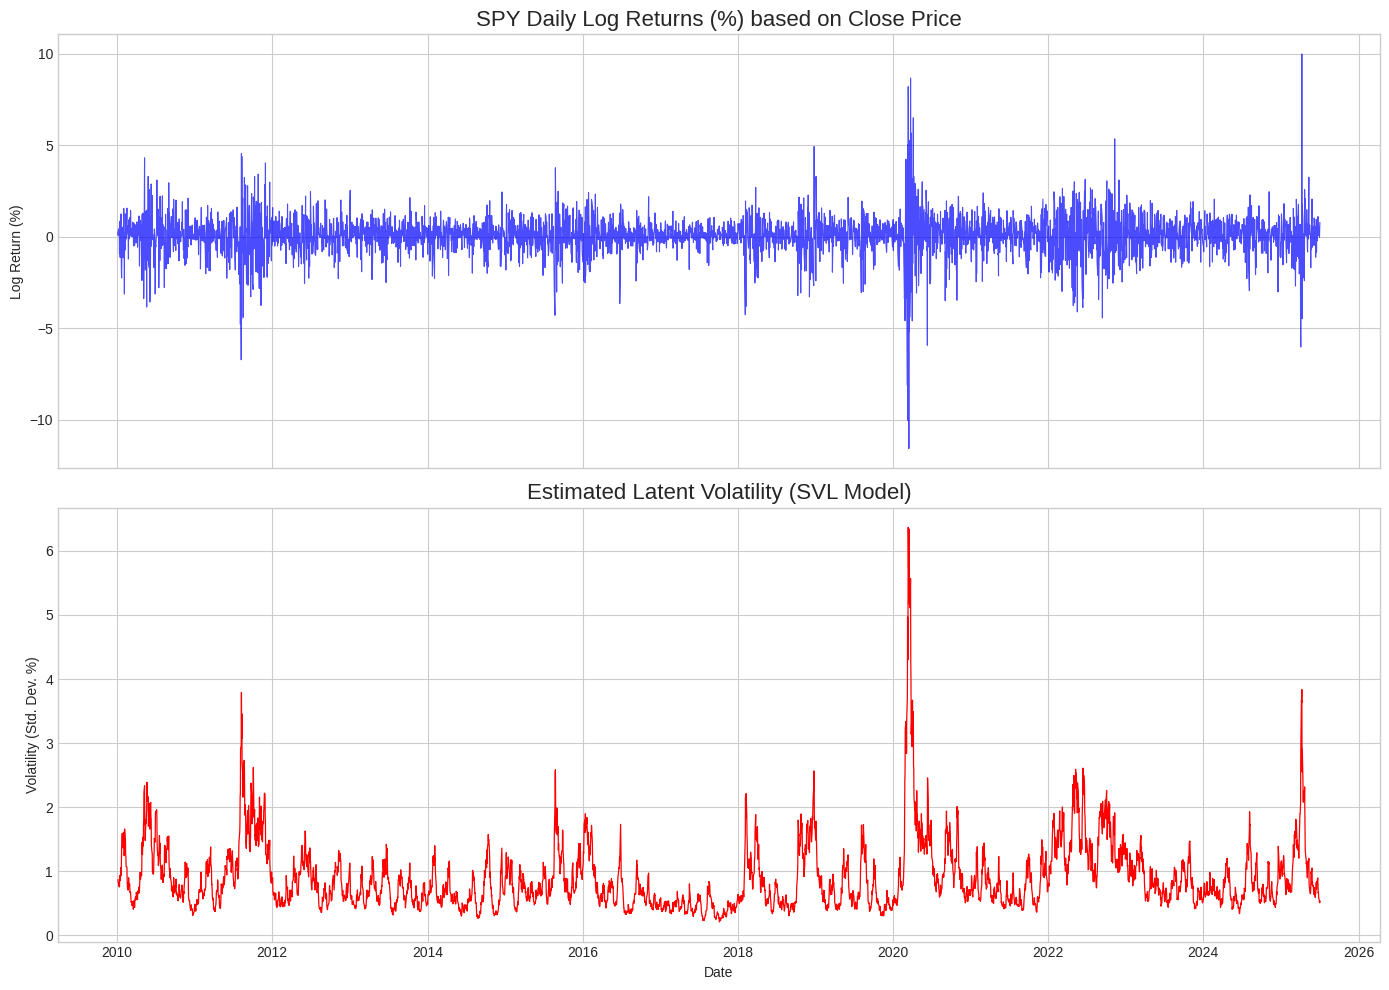

In [ ]:
# ==============================================================================
# Step 0: Install necessary libraries
# ==============================================================================
# This command ensures all modern, compatible libraries are installed.
!pip install pymc "pytensor>=2.10" yfinance arviz -q

# ==============================================================================
# Step 1: Import Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import pytensor.tensor as tt
import arviz as az
import yfinance as yf
import warnings

# Suppress warnings for a cleaner output
warnings.filterwarnings("ignore")

# Set a plot style with a white background for clarity
plt.style.use('seaborn-v0_8-whitegrid') # A modern style with a white background
%matplotlib inline

# ==============================================================================
# Step 2: Define All Functions and Classes
# ==============================================================================

# The log-probability function for our custom AR(1) process
def logp_mv_ar1(x, mu, phi, sigmav):
    """
    Log-probability for the stochastic volatility AR(1) process.
    x_t = (1-phi)*mu + phi*x_{t-1} + sigmav*eta_t
    """
    alpha = (1. - phi) * mu
    logp_init = pm.logp(pm.Normal.dist(mu=mu, sigma=sigmav), x[0])
    logp_innov = pm.logp(pm.Normal.dist(mu=alpha + phi * x[:-1], sigma=sigmav), x[1:])
    return logp_init + tt.sum(logp_innov)

# Function to build the SVL model
def make_svl_model(data):
    with pm.Model() as svl_model:
        mu = pm.Normal('mu', mu=0., sigma=10.)
        phistar = pm.Beta('phistar', alpha=20., beta=1.5)
        phi = pm.Deterministic('phi', 2. * phistar - 1.)
        recsigmav2 = pm.Gamma('recsigmav2', alpha=2.5, beta=0.25)
        sigmav = pm.Deterministic('sigmav', pm.math.sqrt(1. / recsigmav2))
        rho = pm.Uniform('rho', lower=-1., upper=1.)

        x = pm.CustomDist(
            'x',
            mu,
            phi,
            sigmav,
            logp=logp_mv_ar1,
            shape=len(data) + 1
        )

        y_mean = (rho / sigmav) * pm.math.exp(0.5 * x[:-1]) * (x[1:] - (1. - phi) * mu - phi * x[:-1])
        y_sd = pm.math.sqrt(pm.math.exp(x[:-1]) * (1 - rho**2))

        y_obs = pm.Normal('y_obs', mu=y_mean, sigma=y_sd, observed=data)

    return svl_model

# ==============================================================================
# Step 3: Main Execution Block
# ==============================================================================

# --- Data Acquisition and Preparation ---
ticker = 'SPY'
start_date = '2010-01-01'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')

print(f"Running on PyMC v{pm.__version__}")
print(f"\nDownloading data for {ticker} from {start_date} to {end_date}...")
spy_data = yf.download(ticker, start=start_date, end=end_date, progress=False)

if spy_data.empty:
    print('Data download failed. Please check the ticker or your network connection.')
else:
    print(f'Data downloaded successfully. Shape: {spy_data.shape}')
    spy_data['log_return'] = np.log(spy_data['Close'] / spy_data['Close'].shift(1))
    spy_data.dropna(inplace=True)
    log_returns = spy_data['log_return'].values * 100
    dates = spy_data.index

    # Visualize the log returns
    plt.figure(figsize=(14, 6))
    plt.plot(dates, log_returns, alpha=0.8, color='b', linewidth=0.8)
    plt.title(f'{ticker} Daily Log Returns (%) based on Close Price', fontsize=16)
    plt.ylabel('Log Return (%)')
    plt.xlabel('Date')
    plt.show()

    # --- Model Definition and Calibration ---
    print("\nDefining and compiling the SVL model...")
    svl_model = make_svl_model(log_returns)

    print("Starting MCMC sampling... (This may take several minutes)")
    with svl_model:
        trace = pm.sample(
            tune=2000,
            draws=2000,
            cores=1,
            target_accept=0.9,
            init='adapt_diag'
        )
    print("Sampling complete.")

    # --- Results Analysis and Visualization ---
    print("\nGenerating diagnostic plots and analyzing results...")

    # 1. Trace Plot and Posterior Distributions
    az.plot_trace(trace, var_names=['mu', 'phi', 'sigmav', 'rho'])
    plt.tight_layout()
    plt.show()

    # 2. Summary Statistics
    summary = az.summary(trace, var_names=['mu', 'phi', 'sigmav', 'rho'])
    print("\nPosterior Summary Statistics:")
    print(summary)

    # 3. Visualize the Estimated Latent Volatility
    print("\nVisualizing the estimated latent volatility...")

    # Use the modern ArviZ/xarray API to access posterior samples
    x_posterior_samples = trace.posterior["x"]
    x_mean = x_posterior_samples.mean(dim=("chain", "draw")).values

    # Convert log-volatility to actual volatility (standard deviation)
    volatility_est = np.exp(x_mean / 2)

    # Create a figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Plot 1: Log returns
    axes[0].plot(dates, log_returns, alpha=0.7, color='b', linewidth=0.8)
    axes[0].set_title(f'{ticker} Daily Log Returns (%) based on Close Price', fontsize=16)
    axes[0].set_ylabel('Log Return (%)')

    # Plot 2: Estimated Volatility
    axes[1].plot(dates, volatility_est[:-1], color='red', linewidth=0.9)
    axes[1].set_title('Estimated Latent Volatility (SVL Model)', fontsize=16)
    axes[1].set_ylabel('Volatility (Std. Dev. %)')
    axes[1].set_xlabel('Date')

    plt.tight_layout()
    plt.show()